# Advanced Feature Engineering

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Advanced-Feature-Engineering" data-toc-modified-id="Advanced-Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Advanced Feature Engineering</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#LyricsManager.py" data-toc-modified-id="LyricsManager.py-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LyricsManager.py</a></span></li><li><span><a href="#MoodyLyrics-issue" data-toc-modified-id="MoodyLyrics-issue-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MoodyLyrics issue</a></span></li><li><span><a href="#New-features" data-toc-modified-id="New-features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>New features</a></span><ul class="toc-item"><li><span><a href="#Dataset-Stats" data-toc-modified-id="Dataset-Stats-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dataset Stats</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Extra-test-set" data-toc-modified-id="Extra-test-set-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Extra test set</a></span></li></ul></li><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Artificial Neural Network</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li><li><span><a href="#SVM" data-toc-modified-id="SVM-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#eXtreme-Gradient-Boost" data-toc-modified-id="eXtreme-Gradient-Boost-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>eXtreme Gradient Boost</a></span></li><li><span><a href="#Naive-Bayesian-Classifier" data-toc-modified-id="Naive-Bayesian-Classifier-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Naive Bayesian Classifier</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-5.7.1"><span class="toc-item-num">5.7.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
import spacy
import os
import sys
import warnings
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

In [2]:
# Read extra test set
extra_test_path = './datasets/extra_test.csv'
extra_test = pd.read_csv(extra_test_path)

In [3]:
def plot_confusion_matrix(cm, classes = emotion_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Introduction
**Previously on Sara&Mario project**: 
<ol>
    <li>*MoodyLyrics* stats analysis</li>
    <li>Lyrics classification using the main classifiers</li>
    <li>Emotion classification by just considering the song title</li> 
</ol>
Now, following the last meeting discussion we: 
<ol>
    <li>Wrote a script to create the dataset *SpotifyURI*, *List of PlaylistIDs*, *MoodyLyric_Emotion*</li>
    <li>Wrote a script to detect all duplicated songs in MoodyLyrics to fill a bug report</li>
    <li>Added new features for the classification task</li>
</ol>

# LyricsManager.py
After downloading the Spotify RecSys Challenge dataset we wrote a script that: <br>
<ul>
    <li>Given as input: the *Spotify playlist dataset folder*, and an output folder, creates a data structure to store for each song:<br>
        <*SpotifyURI*, *PlaylistIDs*, *TrackInformation*, *Emotion*><br>
        where: 
            <ul>
                <li>*SpotifyURI* is the songID</li>
                <li>*PlaylistsIDs* is the list of playlist in which the song appear</li>
                <li>*TrackInformation* is the list of information taken from Spotify dataset</li>
                <li>*Emotion* is an optional field, present only if the song is also contained in the MoodyLyrics dataset, that contains the emotion label for the song
    </li>
            </ul>
      <li>Can load Spotify songs datastructure (if already existing)</li>
            <li>Given as input a SpotifyURI it can download lyrics from lyricwikia</li>
</ul>

# MoodyLyrics issue
New week we detected duplicate information in MoodyLyrics. Now we can generate a .csv file capable of reporting those duplicates.

Now it's time to fill a bug.

# New features
Starting from MoodyLyrics we are going to create a new dataset with a lot of new features. <br>
<ul>
    <li>**Title_vector**</li>
    <li>**Lyric_vector**</li>
    <li>**%Rhymes**:<br> defined as the percentage of the number of rhymes over the number of total lines. A rhyme is defined as a rhyme between two following lines.</li>
    <li>**%Past_tense_verbs**:<br> defined as the the percentage of the number of past tense verbs over the total number of verbs.</li>
    <li>**%Present_tense_verbs**:<br>  defined as the the percentage of the number of present tense verbs over the total number of verbs.</li>
    <li>**%Future_tense_verbs**:<br>  defined as the the percentage of the number of future tense verbs over the total number of verbs, where future is just will + base form.</li>
    <li>**%ADJ**:<br> Percentage of adjectives over the total number of words.</li>
    <li>**%ADP**:<br> Percentage of adpositions (e.g. in, to, during) over the total number of words.</li>
    <li>**%ADV**:<br> Percentage of adverbs (e.g. very, tomorrow, down, where, there) over the total number of words.</li>
    <li>**%AUX**:<br> Percentage of auxiliaries (e.g. is, has (done), will (do), should (do)) over the total number of words.</li>
    <li>**%INTJ**:<br> Percentage of interjections (e.g. psst, ouch, bravo, hello) over the total number of words.</li>
    <li>**%NOUN**:<br> Percentage of nouns over the total number of words.</li>
    <li>**%NUM**:<br> Percentage of numerals over the total number of words.</li>
    <li>**%PRON**:<br> Percentage of pronouns (e.g. I, you, he, she, myself, themselves, somebody,...) over the total number of words.</li> 
    <li>**%PROPN**:<br> Percentage of proper nouns (e.g. Mary, John) over the total number of words.</li>
    <li>**%PUNCT**:<br> Percentage of puntuctuation (e.g. ., (, ), ?) over the total number of words.</li>
    <li>**%VERB**:<br> Percentage of verbs over the total number of words.</li>
    <li>**Selfish_degree**:<br> Percentage of 'I' pronouns over the total number of pronouns</li>
    <li>**%Echoism**:<br> Percentage of echoism over the total number of words, where an echoism is either a sequence of two subsequent repeated words or the repetition of a vowel in a word. </li>
    <li>**%Duplicates**:<br> Percentage of duplicate words over the total number of words</li>
    <li>**isTitleInLyric**:<br> Boolean, true if the title string is also a substring of the lyric</li>
    <li>**sentiment**:<br> Sentiment between -1 and 1</li>
    <li>**subjectivity degree**:<br> Degree of subjectivity of the text</li>
</ul>

The sentiment and subjectivity analysis was done using [TextBlob](http://textblob.readthedocs.io/en/dev/index.html) Python NLP library.

## Dataset Stats

In [4]:
import pandas as pd

In [5]:
dataset = pd.read_csv('./datasets/moodylyrics_featurized.csv')               

In [6]:
useless_columns = [ 'ID','ARTIST', 'SONG_TITLE', 'EMOTION', 'X_FREQUENCIES', 'SPACE_FREQUENCIES']

In [7]:
print(len(dataset.columns))

38


In [8]:
dataset.head(5)

,Unnamed: 0,ID,ARTIST,SONG_TITLE,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,...,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,SENTIMENT,SUBJECTIVITY,EMOTION
0,0,0,.38 Special,Fantasy Girl,[-2.59583928e-02 1.46213636e-01 -2.40031540e-...,[-0.1325517 0.07027499 -0.353215 0.047058...,35,174,0.0,0.291667,...,0.000000,0.051724,0.0,0.0,0.241379,0.0,0.0,0.137407,0.610000,relaxed
1,1,1,.38 Special,Second Chance,[-1.19381584e-02 2.30911389e-01 -1.93970740e-...,[-2.17199996e-02 3.36335003e-01 -1.79910004e-...,50,318,0.0,0.368421,...,0.000000,0.006289,0.0,0.0,0.345912,0.0,0.0,0.112576,0.310317,happy
2,2,2,22-20s,Hold On,[ 5.15404232e-02 1.07047103e-01 -2.46115208e-...,[-9.10529941e-02 1.45800002e-02 -2.31949985e-...,38,217,0.0,0.461538,...,0.000000,0.000000,0.0,0.0,0.313364,0.0,0.0,0.200000,0.400000,angry
3,3,3,3 Inches Of Blood,Trial Of Champions,[-7.87018538e-02 7.39747062e-02 -8.28025416e-...,[-3.40596698e-02 7.27466643e-02 2.60249972e-...,33,179,0.0,0.000000,...,0.011173,0.011173,0.0,0.0,0.245810,0.0,0.0,-0.015899,0.606838,angry
4,4,4,3 of Hearts,Is It Love,[-9.74312518e-03 2.82311559e-01 -1.53461650e-...,[ 1.86306313e-02 4.64353323e-01 -1.01861566e-...,45,252,0.0,0.223881,...,0.000000,0.166667,0.0,0.0,0.305556,0.0,0.0,0.479429,0.601429,happy


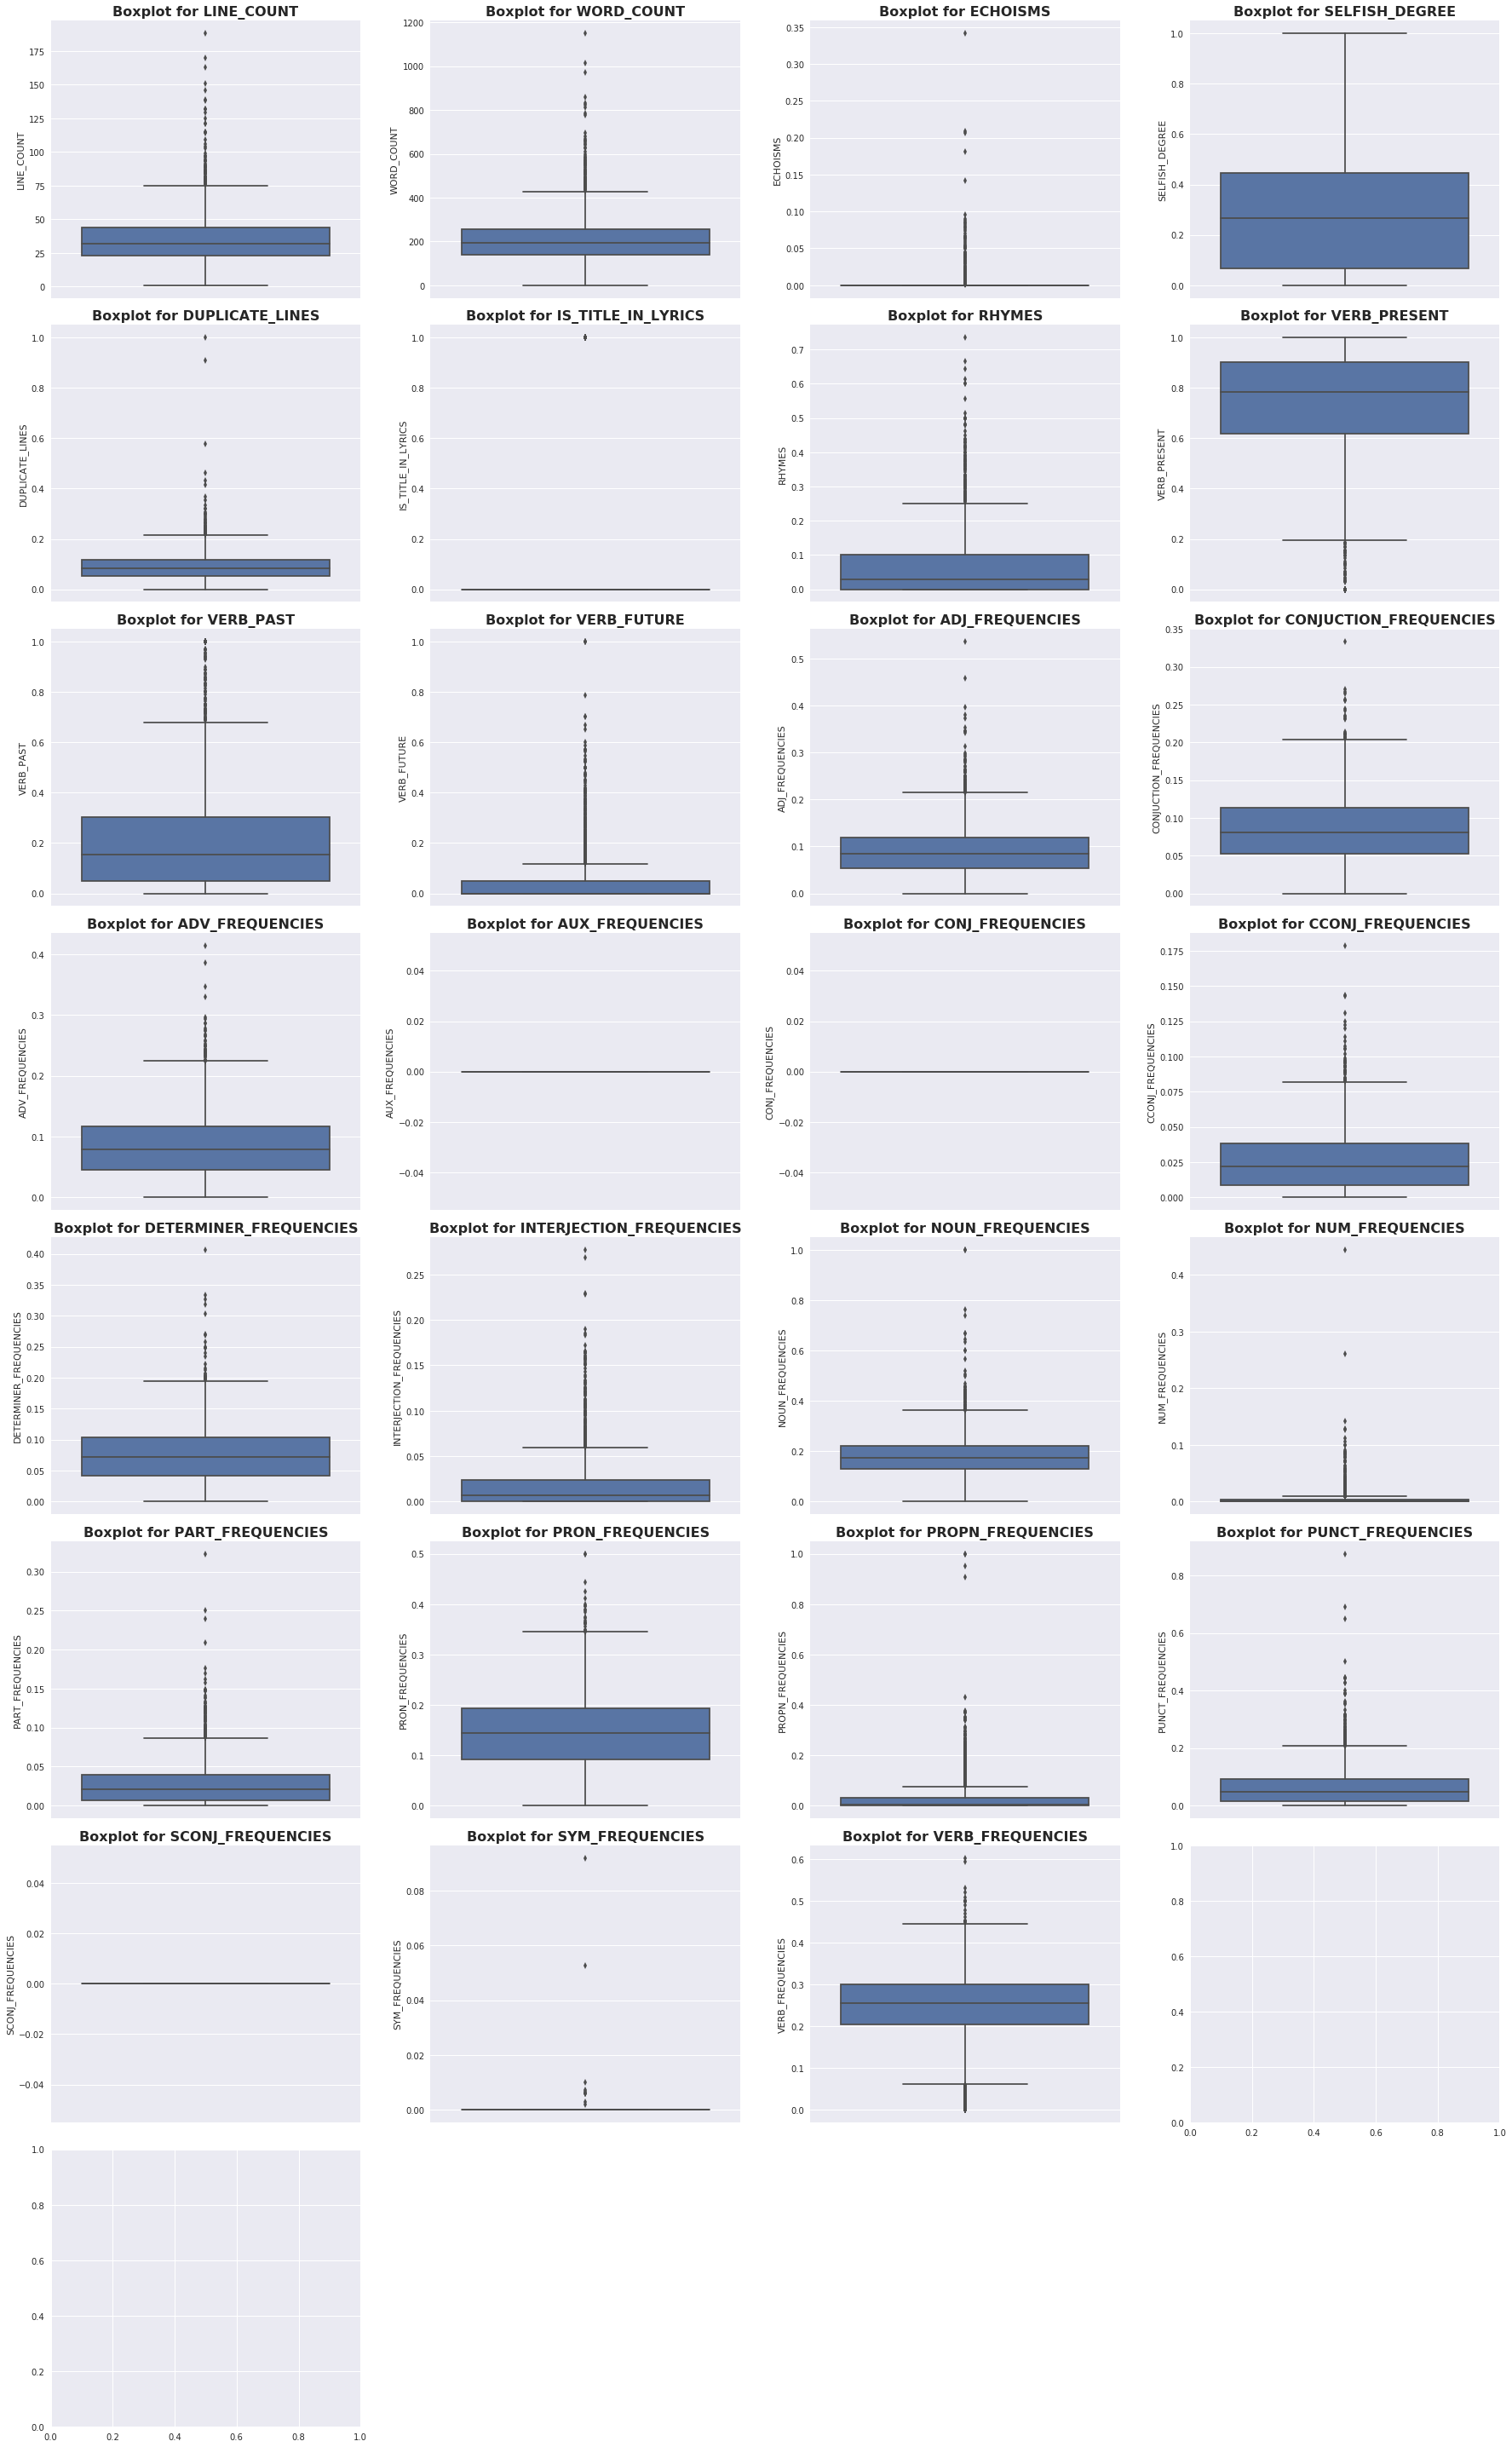

In [12]:
tmp_df = dataset.drop(useless_columns + ['LYRICS_VECTOR', 'TITLE_VECTOR'],axis=1)

f, axarr = plt.subplots(8, 4, figsize=(25,40))
k = 0
for feature in tmp_df.columns:
    (i, j) = divmod(k, 4)
    axarr[i,j] = sns.boxplot(y=tmp_df[feature], ax=axarr[i,j])
    axarr[i,j].set_title('Boxplot for {}'.format(feature), fontsize=16, weight='bold')
    k += 1
plt.tight_layout()
f.delaxes(axarr[-1,-1])
f.delaxes(axarr[-1,-2])
f.delaxes(axarr[-1,-3])

## Feature Selection

In [9]:
selected_columns = [
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]

In [10]:
dataset = dataset[selected_columns]
extra_test = extra_test[selected_columns]

In [11]:
tmp_df = dataset.drop(['EMOTION'], axis=1)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)

In [12]:
y = dataset['EMOTION'].as_matrix().T

In [13]:
print(X_vect.shape)
print(y.shape)

(2452, 312)
(2452,)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

### Extra test set

In [15]:
tmp_df = extra_test.drop(['EMOTION'], axis=1)
X_test_extra = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_test_extra.append(np.array(sub_list))
X_test_extra = np.array(X_test_extra)

In [16]:
y_test_extra = extra_test['EMOTION'].as_matrix().T

## Artificial Neural Network

In [286]:
from keras.utils import np_utils

## Encode outputs

encoder = LabelEncoder()

encoder.fit(y_train)

encoded_Y_train = encoder.transform(y_train)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_test_extra = encoder.transform(y_test_extra)
y_train_nn = np_utils.to_categorical(encoded_Y_train)
y_test_nn = np_utils.to_categorical(encoded_Y_test)
y_test_extra_nn = np_utils.to_categorical(encoded_Y_test_extra)

In [287]:
cm_labels = encoder.inverse_transform([0, 1, 2, 3])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [288]:
from sklearn.preprocessing import StandardScaler

## Scale inputs

sc = StandardScaler()

sc.fit(X_train)

X_train_nn = sc.transform(X_train)
X_test_nn = sc.transform(X_test)
X_test_extra_nn = sc.transform(X_test_extra)

In [289]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
    
from sklearn.utils import class_weight
    
def build_ann(optimizer='adam', input_size=X_vect.shape[1]):
    classifier = Sequential()
    # Add input layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', 
                         activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
    
    # Add hidden layers
    classifier.add(Dense(units = 40, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
       
    # Add output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))
    
    # Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [290]:
# Compute input weights to balance classes
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [291]:
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 256, epochs = 100, 
               verbose=False, class_weight=cw)
y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

Accuracy: 90.84


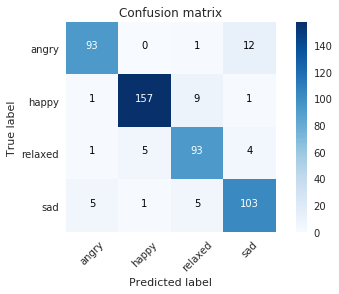

In [292]:
cm = confusion_matrix(encoded_Y_test, y_pred)
plot_confusion_matrix(cm, classes=cm_labels)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

In [293]:
y_pred_extra = classifier.predict(X_test_extra_nn)
y_pred_extra = np.argmax(y_pred_extra, axis=1)

Accuracy: 35.00


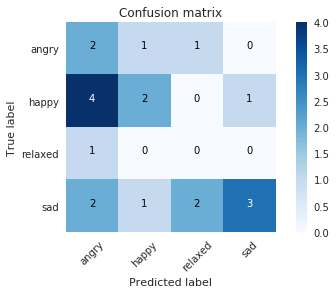

In [294]:
cm = confusion_matrix(encoded_Y_test_extra, y_pred_extra)
plot_confusion_matrix(cm, classes=cm_labels)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(encoded_Y_test_extra)
print('Accuracy: %0.2f' % (accuracy*100))

In [25]:
extra_test = pd.read_csv(extra_test_path)
for (idx, row) in extra_test.iterrows():
    print('Prediction for: "{}" from "{}"'.format(row['SONG_TITLE'], row['ARTIST']))
    print('\t - {}'.format(encoder.inverse_transform(y_pred_extra[idx])))

Prediction for: "Don't Worry, Be Happy" from "Bobby McFerrin"
	 - happy
Prediction for: "Don't Stop me Now" from "Queen"
	 - angry
Prediction for: "Happy" from "Pharrell Williams"
	 - happy
Prediction for: "I'm a believer" from "The Monkees"
	 - happy
Prediction for: "Toxic" from "Britney Spears"
	 - angry
Prediction for: "Buttons" from "The Pussycat Dolls"
	 - sad
Prediction for: "Crazy In Love" from "Beyoncé"
	 - happy
Prediction for: "Everybody Hurts" from "R.E.M."
	 - sad
Prediction for: "Someone Like You" from "Adele"
	 - angry
Prediction for: "Wish you were here" from "Pink Floyd"
	 - sad
Prediction for: "Hurt" from "Johnny Cash"
	 - angry
Prediction for: "Smells like teen spirit" from "Nirvana"
	 - relaxed
Prediction for: "My Boo" from "Usher"
	 - happy
Prediction for: "Rock Your Body" from "Justin Timberlake"
	 - relaxed
Prediction for: "It Wasn't Me" from "Shaggy"
	 - sad
Prediction for: "Killing in the name" from "Rage Against the Machine"
	 - angry
Prediction for: "Stronger"

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

### Playlist Classification

In [302]:
import json

n_pl = 5

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [303]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [304]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [305]:
import lyricwikia

In [306]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

,PlaylistPid,PlaylistName,TrackUri,ArtistName,TrackName,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,...,PRON_FREQUENCIES,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,SENTIMENT,SUBJECTIVITY
0,0,Test,0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),"[-0.028712682, 0.17780696, -0.12608747, -0.051...","[-0.25141445, 0.24385495, 0.07654981, 0.014219...",111,503,0.0,...,0.135189,0.045726,0.349901,0.0,0.0,0.226640,0.0,0.0,0.095387,0.330568
1,0,Test,0,Britney Spears,Toxic,"[-0.020864742, 0.19054435, -0.22505683, -0.055...","[-0.67908, 0.0347, -0.35805, 0.36178, -0.60825...",40,276,0.0,...,0.242754,0.003623,0.134058,0.0,0.0,0.304348,0.0,0.0,-0.079556,0.565389
2,0,Test,0,Beyoncé,Crazy In Love,"[-0.03404636, 0.18371318, -0.23614396, -0.0203...","[-0.04562767, 0.23236366, -0.043523327, -0.091...",90,693,0.0,...,0.176046,0.021645,0.079365,0.0,0.0,0.277056,0.0,0.0,0.022569,0.639406


In [307]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

(146, 312)

In [308]:
X_vect_nn = sc.transform(X_vect)

In [309]:
y_pred = classifier.predict(X_vect_nn, verbose=0)

In [310]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [311]:
finalDf[['angry', 'happy', 'relaxed', 'sad']].head(5)

,angry,happy,relaxed,sad
0,0.133965,0.001857,0.058588,0.805590
1,0.898911,0.004431,0.004110,0.092547
2,0.518446,0.331931,0.041477,0.108146
3,0.013696,0.020714,0.870789,0.094801
4,0.093781,0.001780,0.073430,0.831010


In [312]:
playlistDf = finalDf.groupby(by='PlaylistPid').agg({'happy': 'mean', 'sad': 'mean', 'angry': 'mean', 'relaxed': 'mean'})

In [313]:
playlistDf.head(n_pl)

,sad,happy,relaxed,angry
PlaylistPid,,,,
0,0.322220,0.205436,0.214933,0.257411
1,0.334601,0.077030,0.342805,0.245564
2,0.541647,0.149624,0.070165,0.238564
3,0.551395,0.116639,0.125314,0.206652
4,0.557120,0.040193,0.144124,0.258564


## Logistic Regression

In [295]:
from sklearn.linear_model import LogisticRegression
def evaluate_logreg(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(penalty='l2', dual=False, C=0.15, 
                                    solver='newton-cg', multi_class='multinomial', random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=cm_labels)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


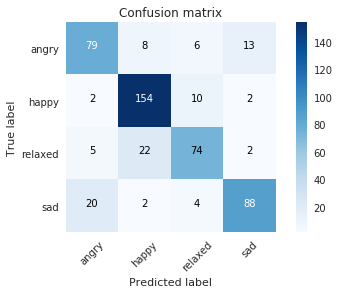

In [300]:
evaluate_logreg(X_train, y_train, X_test, y_test)

Accuracy of logistic regression classifier on test set: 0.55


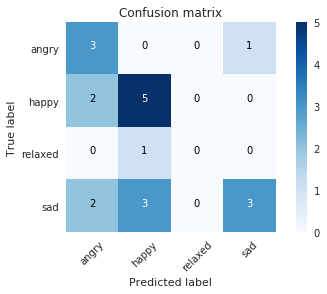

In [301]:
evaluate_logreg(X_train, y_train, X_test_extra, y_test_extra)

### Playlist Classification

In [314]:
clf = LogisticRegression(penalty='l2', dual=False, C=0.15, 
                         solver='newton-cg', multi_class='multinomial', random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [315]:
import json

n_pl = 5

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [316]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [317]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [318]:
import lyricwikia

In [ ]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

In [319]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

(146, 312)

In [320]:
y_pred = clf.predict_proba(X_vect)

In [321]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [322]:
finalDf[['angry', 'happy', 'relaxed', 'sad']].head(5)

,angry,happy,relaxed,sad
0,0.312753,0.108469,0.331739,0.247038
1,0.396905,0.143597,0.187042,0.272456
2,0.270989,0.379825,0.200085,0.149100
3,0.230710,0.332525,0.277543,0.159222
4,0.356662,0.129403,0.310281,0.203654


In [323]:
playlistDf = finalDf.groupby(by='PlaylistPid').agg({'happy': 'mean', 'sad': 'mean', 'angry': 'mean', 'relaxed': 'mean'})

In [324]:
playlistDf.head(n_pl)

,sad,happy,relaxed,angry
PlaylistPid,,,,
0,0.189035,0.272832,0.250399,0.287734
1,0.231740,0.172384,0.270675,0.325201
2,0.387876,0.176501,0.164940,0.270683
3,0.287450,0.176249,0.243194,0.293106
4,0.250735,0.183312,0.220035,0.345918


## SVM 

In [856]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_)

In [857]:
from sklearn.svm import SVC

In [858]:
clf = SVC(C=100, kernel='rbf', shrinking=True, probability=False, )
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy of SVM classifier on test set: 0.70


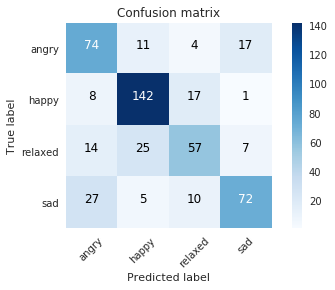

In [859]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=cm_labels)
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM classifier on extra test set: 0.40


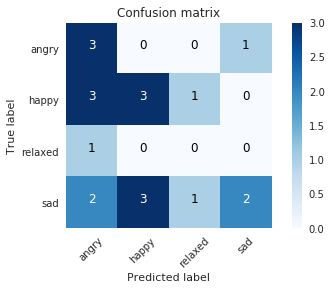

In [860]:
y_pred_extra = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred_extra), classes=cm_labels)
print('Accuracy of SVM classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

## eXtreme Gradient Boost

In [707]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.83 (+/- 0.04)


In [715]:
clf = GradientBoostingClassifier(learning_rate=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy of Gradient Boost classifier on test set: 0.81


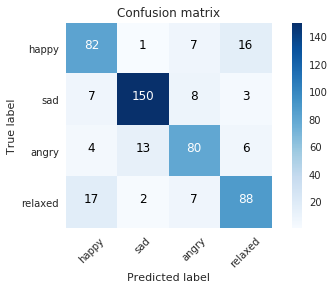

In [716]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of Gradient Boost classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of Gradient Boosting classifier on extra test set: 0.41


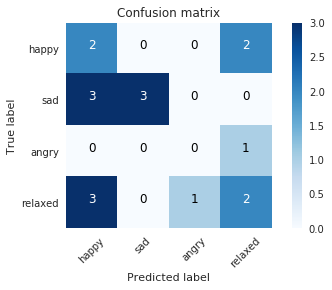

In [717]:
y_pred = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred))
print('Accuracy of Gradient Boosting classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

## Naive Bayesian Classifier

In [214]:
from sklearn.preprocessing import MinMaxScaler

## Scale inputs

sc = MinMaxScaler()

sc.fit(X_train)

X_train_nb = sc.transform(X_train)
X_test_nb = sc.transform(X_test)
X_test_extra_nb = sc.transform(X_test_extra)

In [215]:
from sklearn.naive_bayes import MultinomialNB

In [216]:
clf = MultinomialNB(alpha=0.0, fit_prior=False)
clf.fit(X_train_nb, y_train)

MultinomialNB(alpha=0.0, class_prior=None, fit_prior=False)

Accuracy of Naive-Bayes classifier on test set: 0.65


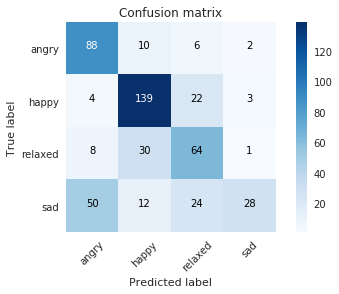

In [217]:
y_pred = clf.predict(X_test_nb)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=cm_labels)
print('Accuracy of Naive-Bayes classifier on test set: {:.2f}'.format(clf.score(X_test_nb, y_test)))

Accuracy of Naive-Bayes classifier on extra test set: 0.55


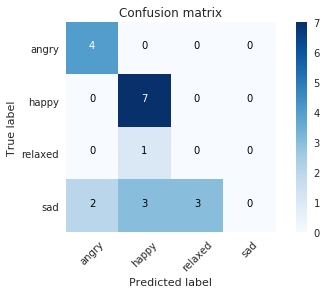

In [218]:
y_pred = clf.predict(X_test_extra_nb)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred), classes=cm_labels)
print('Accuracy of Naive-Bayes classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra_nb, y_test_extra)))

### Playlist Classification

In [219]:
import json

n_pl = 5

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [220]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [221]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [222]:
import lyricwikia

In [ ]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

In [223]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

(146, 312)

In [224]:
X_vect_scaled = sc.transform(X_vect)

In [227]:
y_pred = clf.predict_proba(X_vect_scaled)

In [228]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [229]:
finalDf[['angry', 'happy', 'relaxed', 'sad']].head(5)

,angry,happy,relaxed,sad
0,0.001581,0.998419,8.397054e-29,1.170221e-30
1,0.012917,0.987083,1.876200e-16,2.684193e-18
2,0.000114,0.999886,1.668742e-39,5.793295e-42
3,0.001007,0.998993,9.990588e-29,7.160484e-31
4,0.000587,0.999413,2.526268e-33,1.522402e-35


In [230]:
playlistDf = finalDf.groupby(by='PlaylistPid').agg({'happy': 'mean', 'sad': 'mean', 'angry': 'mean', 'relaxed': 'mean'})

In [231]:
playlistDf.head(n_pl)

,sad,happy,relaxed,angry
PlaylistPid,,,,
0,1.975040e-12,0.993345,7.635374e-11,0.006655
1,2.049313e-02,0.941977,5.333429e-03,0.032197
2,9.735730e-13,0.974682,1.963632e-12,0.025318
3,5.368889e-07,0.951358,1.789475e-05,0.048624
4,4.542883e-14,0.979711,2.536567e-12,0.020289


# Conclusion
- The neural network is certainly the best classifier for our purpose
- We are always quite good at classifying sad songs but we often lack in performances while classifying other emotions